In [1]:
from pandas import Timedelta, to_datetime
from matplotlib.pyplot import subplots, savefig, show, legend, close
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

subset_data: bool = False


def make_biometrics_plots_together_matplotlib(
    data: defaultdict[str, defaultdict[str, defaultdict[str, Series]]],
    user_id: str,
    session_id: str,
    dataset: str,
    experiment_info: DataFrame,
    **kwargs,
) -> None:
    data = {key: val for key, val in data.items() if val is not None}
    fig, axs = subplots(
        len(data.keys()), 1, figsize=(14, 11 * len(data.keys())), sharex=True
    )
    if len(data.keys()) == 1:
        axs = [axs]
    
    for n, (data_type, physiological_data) in tqdm(
        enumerate(data.items()), desc="Plotting data", total=len(data.keys())
    ):
        if physiological_data is None:
            continue

        for side, specific_side_data in physiological_data.items():
            user_data: DataFrame = specific_side_data[user_id]

            if data_type == "EDA":
                eda_type: str = kwargs["eda_type"]
                data_to_plot = user_data[eda_type]
            else:
                data_to_plot = user_data.iloc[:, 0]

            data_to_plot = data_to_plot.loc[IndexSlice[session_id, :]]
            if subset_data:
                data_to_plot = data_to_plot[:1000]

            data_to_plot.index = to_datetime(data_to_plot.index)
            axs[n].plot(
                data_to_plot.index,
                data_to_plot.values,
                label=side,
                linestyle="-",
            )
            axs[n].set_title(data_type)

            # del data_to_plot
            # garbage_collect()

        # session_id_corrected: Timestamp = to_datetime(
        #     session_ids["left"].split("-")[0], format="%y%m%d"
        # )  + Timedelta("1D")
        # session_id_corrected: str = str(session_id_corrected.date())
        if dataset == "mwc2022":
            start_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "actual_bed_time"]
            )
            end_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "wake_up_time"]
            )
            # start_exp = start_exp.tz_localize("Europe/Rome")
            # end_exp = end_exp.tz_localize("Europe/Rome")

            axs[n].axvspan(
                xmin=start_exp,
                xmax=end_exp,
                color="#828282",
                alpha=0.3,
                label="sleep time",
            )
            axs[n].set_ylabel(f"Time")
            axs[n].set_ylabel(f"{data_type}")
        elif dataset == "usi_laughs":
            events = set(
                ["_".join(col.split("_")[1:]) for col in experiment_info.columns]
            )
            for i, event in enumerate(events):
                start_exp = Timestamp(experiment_info.loc[user_id, f"start_{event}"])
                end_exp = Timestamp(experiment_info.loc[user_id, f"end_{event}"])
                if "baseline" in event and i == 0:
                    label = "baseline"
                elif "baseline" not in event:
                    label = event
                else:
                    label = None

                axs[n].axvspan(
                    xmin=start_exp,
                    xmax=end_exp,
                    color="#828282" if "baseline" in event else "#548572",
                    alpha=0.3,
                    label=label,
                )
                axs[n].set_ylabel(f"Time")
                axs[n].set_ylabel(f"{data_type}")
        else:
            raise ValueError(
                f"Received as dataset {dataset}, but only mwc2022 and usi_laughs are supported"
            )

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        fontsize="x-large",
        title="Side",
        title_fontsize="xx-large",
        #    loc='best'
    )
    # legend()
    fig.suptitle(
        f"Plots for all singals for user {user_id}, session {session_id}",
        fontsize=30,
        y=0.97,
    )
    savefig(f"../visualizations/{dataset}_{user_id}_{session_id}.pdf")
    # show()
    close()

    return start_exp, end_exp


# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# USILaughs

The artefacts scripts have been moved inside the EDA filtering.

## Cognitive Load Info

In [2]:
from pandas import read_csv, to_datetime
from pandas import IndexSlice, DataFrame
import pandas as pd

pd.options.display.precision = 5

In [3]:
def move_event_to_columns(df):
    starts = {}
    ends = {}
    for event in df.index.get_level_values(1).unique():
        starts[f"start_{event}"] = df.loc[IndexSlice[:, event], "start"].values
        ends[f"end_{event}"] = df.loc[IndexSlice[:, event], "end"].values
    return DataFrame({**starts, **ends})


experiment_info = read_csv(
    "../data.nosync/usilaughs/all_experimento_info.csv", index_col=[0, 1]
)
indexes_to_drop = [
    idx
    for idx in experiment_info.index
    if "baseline" not in idx[1] and "cognitive_load" not in idx[1]
]
experiment_info = experiment_info.drop(indexes_to_drop, inplace=False)
experiment_info = experiment_info.groupby(axis=0, level=0, group_keys=True).apply(
    move_event_to_columns
)
experiment_info.index = experiment_info.index.droplevel(1)


In [4]:
experiment_info = experiment_info.applymap(to_datetime)
experiment_info = experiment_info.applymap(lambda x: x.tz_localize('Europe/Rome'))

## Physiological Data

In [5]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
eda_data_paths: list[str] = glob(eda_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)

bvp_data = None

# bvp_data_base_path: str = "../data/filtered/*/BVP/*.parquet"
# bvp_data_paths: list[str] = glob(bvp_data_base_path)
# bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# )
# for file in tqdm(bvp_data_paths, desc="Loading BVP data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     bvp_data[side_name][user_name] = read_parquet(file)
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
}
del eda_data
del bvp_data
garbage_collect()

Loading EDA data:   0%|          | 0/67 [00:00<?, ?it/s]

252

After inspection, user 40 has to be removed, since his experiment time and the timestamps from the E4 do not match.

In [6]:
experiment_info = experiment_info.drop('s040', axis=0, inplace=False)
del physiological_data['EDA']['left']['s040']
del physiological_data['EDA']['right']['s040']
# del physiological_data['BVP']['left']['s040']
# del physiological_data['BVP']['right']['s040']

In [7]:
users_left = physiological_data["EDA"]["left"].keys()
users_right = physiological_data["EDA"]["right"].keys()
users = list(set(users_left) & set(users_right))
sessions_all = ['experiment']

In [8]:
# session = session_selection.value
for user in tqdm(sorted(users), desc='Plotting user data', colour='red'):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data=physiological_data,
            user_id=user,
            session_id=session,
            dataset='usi_laughs',
            experiment_info=experiment_info,
            eda_type="mixed-EDA",
        )


Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
users_in_left_side = set(physiological_data['EDA']['left'].keys())
users_in_right_side = set(physiological_data['EDA']['right'].keys())

In [10]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

In this case, I shall perform the segmentation using the raw data. As such, the feature extraction will be 

In [11]:
experiment_info_as_dict: dict[str, Series] = {
    participant: experiment_info.loc[participant, :]
    for participant in list(experiment_info.index.unique())
}

In [12]:
segment_size_in_secs = 4
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [13]:
eda_data = physiological_data['EDA']

In [14]:
# user = "U13"
# info = experiment_info_as_dict[user]
# data = eda_data['left'][user]

In [15]:
from numpy import nan, ndarray
from pandas import Timedelta


def get_session_moment(start: Timestamp, end: Timestamp, info: Series) -> int | float:
    # TODO: check that this is working as expected
    # this method gives 0 if the person is awake and 1 if the person is
    if (end < info["end_baseline_1"]) or (
        (start < info["end_baseline_1"] and end > info["end_baseline_1"])
    ):
        return 0
    elif (start > info["end_baseline_1"] and end < info["start_cognitive_load"]) or (
        start > info["end_cognitive_load"]) or (
            start < info["start_cognitive_load"] and end > info["start_cognitive_load"]
        ):
        return nan
    else:
        return 1


data_segmented_left: list[tuple] = []
data_segmented_right: list[tuple] = []
users = list(set(eda_data["left"].keys()) & set(eda_data["right"].keys()))

for user in tqdm(users, desc='User progress', colour='blue'):
    data_left = eda_data["left"][user]
    data_right = eda_data["right"][user]
    info = experiment_info_as_dict[user]
    
    # FIXME: using sessions like this seems stupid, but allows to reuse code
    # from the other experiment. I should however find a way around it
    sessions_all = ['experiment']
    for session in sessions_all:
        session_data_left: DataFrame = data_left.loc[IndexSlice[session, :], :]
        session_data_right: DataFrame = data_right.loc[IndexSlice[session, :], :]

        session_info = info

        starts_left = session_data_left[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)
        starts_right = session_data_right[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)

        ends_left = (
            session_data_left[::segment_size_in_sampling_rate].index.get_level_values(1)
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )
        ends_right = (
            session_data_right[::segment_size_in_sampling_rate].index.get_level_values(
                1
            )
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )

        segments_left = [
            (
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "Artifact",
                ].values
            )
            for start, end in zip(starts_left, ends_left)
        ]
        segments_right = [
            (
                session_data_right.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "Artifact",
                ].values
            )
            for start, end in zip(starts_right, ends_right)
        ]
        data_segmented_left.append(segments_left)
        data_segmented_right.append(segments_right)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

In [16]:
from numpy import isnan
values_left = [
    val[0]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
values_right = [
    val[0]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

labels_left = [
    val[1]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
labels_right = [
    val[1]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

groups_left = [
    val[2]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]

groups_right = [
    val[2]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

artefacts_left = [
    val[3]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]

artefacts_right = [
    val[3]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]


0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


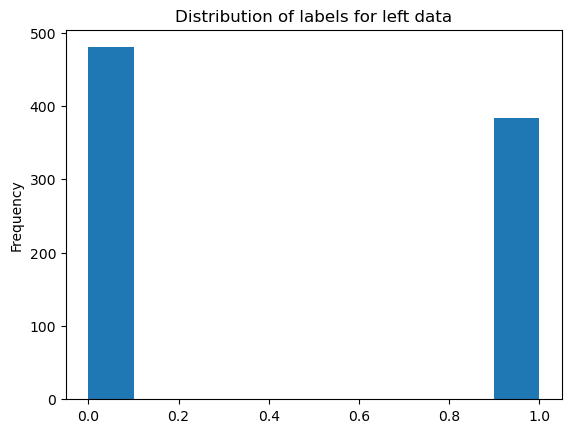

In [17]:
import matplotlib.pyplot as plt

Series(labels_left).plot(kind="hist")
plt.title('Distribution of labels for left data')
print(Series(labels_left).value_counts())
print(Series(labels_left).value_counts()/Series(labels_left).count()*100)

0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


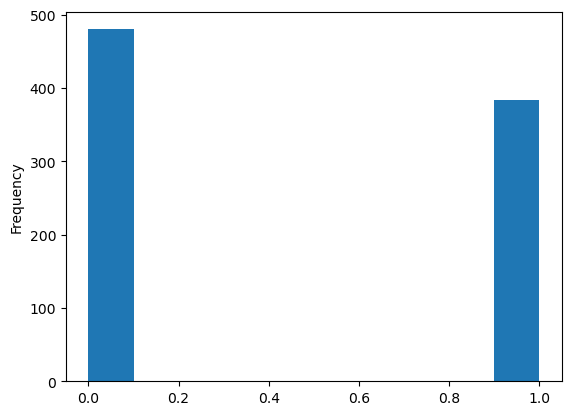

In [18]:
Series(labels_right).plot(kind="hist")
print(Series(labels_right).value_counts())
print(Series(labels_right).value_counts()/Series(labels_right).count()*100)

The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Artefact Removal

In the previous notebook, the training of the model was done without regard for possible artefacts, present in the data. However, it is quite easy to have artefact in EDA data. As such, to methods shall be proposed here for artefact removal.

1. Using Shkurta's method (see https://github.com/shkurtagashi/EDArtifact)
2. Using a simple acc-based logic. The threshold will be decided upon visual inspection and looking at similar literature.

Both methods have been implemented inside the EDA filtering scripts. (only 1 at the moment, but second will follow soon)

## Feature Extraction

In [19]:
from sys import path

path.append("../")
from joblib import Parallel, delayed
from src.feature_extraction.eda import get_eda_features
from numpy import stack

features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

threshold_artefact = 3
artefacts_left = stack(
    [1 if sum(val) > threshold_artefact else 0 for val in artefacts_left]
)
artefacts_right = stack(
    [1 if sum(val) > threshold_artefact else 0 for val in artefacts_right]
)


/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(inf

In [20]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")
print(f"{artefacts_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)
artefacts_left.shape=(864,)


### Artefact Removal

In [21]:
features_left = features_left[~artefacts_left.astype(bool)]
labels_left = labels_left[~artefacts_left.astype(bool)]
groups_left = groups_left[~artefacts_left.astype(bool)]

features_right = features_right[~artefacts_right.astype(bool)]
labels_right = labels_right[~artefacts_right.astype(bool)]
groups_right = groups_right[~artefacts_right.astype(bool)]

In [22]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")
print(f"{artefacts_left.shape=}")

print('Percentage of data removed: %.2f%% ' % (abs(1 - artefacts_left.shape[0]/features_left.shape[0])*100))

features_left.shape=(836, 11)
labels_left.shape=(836,)
groups_left.shape=(836,)
artefacts_left.shape=(864,)
Percentage of data removed: 3.35% 


In [55]:
x = features_left
y = labels_left
groups = groups_left
data = DataFrame(x, index=groups)
data["label"] = y
len(data.loc['s055', 'label'].unique())

1

## ML Prediction

In [69]:
from typing import Callable
from warnings import warn
from imblearn.under_sampling.base import BaseUnderSampler
from imblearn.under_sampling import (
    RandomUnderSampler,
    ClusterCentroids,
    NearMiss,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    CondensedNearestNeighbour,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    InstanceHardnessThreshold,
)


def resampling(
    df: DataFrame,
    resampling_method: BaseUnderSampler = RandomUnderSampler,
    random_state: int = 42,
) -> DataFrame:
    if len(df['label'].unique()) == 1:
        warn(RuntimeWarning(f'User {df.index.unique()[0]} has only one label. Skipping'))
        return None
    x = df.drop(columns=["label"], inplace=False).values
    y = df["label"].values
    
    cc = resampling_method(random_state=random_state)
    x_resampled, y_resampled = cc.fit_resample(x, y)
    result = DataFrame(x_resampled)
    result["label"] = y_resampled
    return result


### 5-fold CV

In [66]:
from sklearn.model_selection import KFold
from lazypredict.Supervised import LazyClassifier
import pandas as pd
def run_cv_ml(x, y, groups):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values


    folds = KFold(n_splits=5, random_state=42, shuffle=True).split(x_resampled, y_resampled)
    all_models = []
    for train_index, test_index in tqdm(folds, desc="Folds progress:", total=5):
        x_train, x_test = x_resampled[train_index], x_resampled[test_index]
        y_train, y_test = y_resampled[train_index], y_resampled[test_index]
        clf = LazyClassifier(predictions=True)
        models, predictions = clf.fit(x_train, x_test, y_train, y_test)
        all_models.append(models)


    averages = (
        pd.concat(all_models)
        .groupby(level=0)
        .mean()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_deviations = (
        pd.concat(all_models)
        .groupby(level=0)
        .std()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_errors = standard_deviations / 5**0.5
    return pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"])

#### LX v LX

In [67]:
run_cv_ml(features_left, labels_left, groups_left)

User Index(['s055'], dtype='object') has only one label. Skipping


Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 17.98it/s]


Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier            0.76              0.76    0.76     0.76   
ExtraTreesClassifier              0.76              0.76    0.76     0.76   
LGBMClassifier                    0.74              0.74    0.74     0.74   
XGBClassifier                     0.74              0.74    0.74     0.74   
BaggingClassifier                 0.73              0.73    0.73     0.73   
LabelSpreading                    0.72              0.72    0.72     0.72   
AdaBoostClassifier                0.72              0.72    0.72     0.72   
SVC                               0.72              0.72    0.72     0.72   
DecisionTreeClassifier            0.71              0.71    0.71     0.71   
LabelPropagation                  0.71              0.71    0.71     0.71   
NuSVC                             0.71              0.71    0.71     0.71   
KNeighborsClassifier              0.70              0.70    0.70     0.70   
ExtraTreeClassifier               0.68              0.68    0.68     0.68   
CalibratedClassifierCV            0.63              0.63    0.63     0.63   
NearestCentroid                   0.63              0.63    0.63     0.63   
LinearDiscriminantAnalysis        0.63              0.62    0.62     0.62   
LogisticRegression                0.62              0.62    0.62     0.62   
RidgeClassifier                   0.62              0.62    0.62     0.62   
RidgeClassifierCV                 0.62              0.62    0.62     0.62   
LinearSVC                         0.62              0.62    0.62     0.62   
BernoulliNB                       0.62              0.62    0.62     0.62   
SGDClassifier                     0.58              0.57    0.57     0.57   
QuadraticDiscriminantAnalysis     0.57              0.57    0.57     0.51   
GaussianNB                        0.57              0.57    0.57     0.51   
PassiveAggressiveClassifier       0.53              0.53    0.53     0.52   
Perceptron                        0.50              0.50    0.50     0.49   
DummyClassifier                   0.48              0.50    0.50     0.31   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier              0.16           0.01              0.01   
ExtraTreesClassifier                0.12           0.01              0.01   
LGBMClassifier                      0.28           0.01              0.01   
XGBClassifier                       0.54           0.01              0.01   
BaggingClassifier                   0.03           0.01              0.01   
LabelSpreading                      0.01           0.01              0.01   
AdaBoostClassifier                  0.08           0.02              0.02   
SVC                                 0.02           0.02              0.02   
DecisionTreeClassifier              0.01           0.02              0.02   
LabelPropagation                    0.01           0.01              0.01   
NuSVC                               0.02           0.01              0.01   
KNeighborsClassifier                0.01           0.00              0.00   
ExtraTreeClassifier                 0.01           0.01              0.01   
CalibratedClassifierCV              0.11           0.01              0.01   
NearestCentroid                     0.01           0.01              0.01   
LinearDiscriminantAnalysis          0.01           0.01              0.01   
LogisticRegression                  0.01           0.01              0.01   
RidgeClassifier                     0.01           0.01              0.01   
RidgeClassifierCV                   0.01           0.01              0.01   
LinearSVC                 

#### RX vs RX

In [68]:
run_cv_ml(features_right, labels_right, groups_right)

User Index(['s055'], dtype='object') has only one label. Skipping


Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 17.12it/s]


Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier            0.83              0.83    0.83     0.83   
ExtraTreesClassifier              0.81              0.81    0.81     0.81   
BaggingClassifier                 0.81              0.81    0.81     0.81   
XGBClassifier                     0.81              0.81    0.81     0.81   
LGBMClassifier                    0.80              0.80    0.80     0.80   
AdaBoostClassifier                0.78              0.78    0.78     0.78   
NuSVC                             0.78              0.78    0.78     0.78   
SVC                               0.77              0.77    0.77     0.77   
KNeighborsClassifier              0.77              0.77    0.77     0.77   
DecisionTreeClassifier            0.77              0.77    0.77     0.77   
ExtraTreeClassifier               0.75              0.76    0.76     0.75   
LabelSpreading                    0.75              0.75    0.75     0.74   
LabelPropagation                  0.74              0.74    0.74     0.74   
LinearSVC                         0.71              0.71    0.71     0.71   
LinearDiscriminantAnalysis        0.71              0.71    0.71     0.71   
CalibratedClassifierCV            0.71              0.71    0.71     0.71   
RidgeClassifierCV                 0.71              0.71    0.71     0.71   
RidgeClassifier                   0.71              0.71    0.71     0.71   
NearestCentroid                   0.71              0.71    0.71     0.71   
LogisticRegression                0.71              0.71    0.71     0.71   
BernoulliNB                       0.70              0.70    0.70     0.70   
GaussianNB                        0.70              0.69    0.69     0.70   
Perceptron                        0.69              0.69    0.69     0.69   
SGDClassifier                     0.66              0.66    0.66     0.65   
QuadraticDiscriminantAnalysis     0.62              0.61    0.61     0.59   
PassiveAggressiveClassifier       0.58              0.58    0.58     0.57   
DummyClassifier                   0.48              0.50    0.50     0.31   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier              0.16           0.01              0.01   
ExtraTreesClassifier                0.12           0.01              0.01   
BaggingClassifier                   0.03           0.01              0.01   
XGBClassifier                       0.56           0.01              0.01   
LGBMClassifier                      0.30           0.01              0.01   
AdaBoostClassifier                  0.09           0.01              0.01   
NuSVC                               0.02           0.01              0.01   
SVC                                 0.02           0.02              0.02   
KNeighborsClassifier                0.01           0.00              0.00   
DecisionTreeClassifier              0.01           0.01              0.01   
ExtraTreeClassifier                 0.01           0.01              0.01   
LabelSpreading                      0.02           0.01              0.01   
LabelPropagation                    0.02           0.01              0.01   
LinearSVC                           0.03           0.01              0.01   
LinearDiscriminantAnalysis          0.01           0.01              0.01   
CalibratedClassifierCV              0.11           0.01              0.01   
RidgeClassifierCV                   0.01           0.01              0.01   
RidgeClassifier                     0.01           0.01              0.01   
NearestCentroid                     0.01           0.01              0.01   
LogisticRegression        

#### LX vs RX

In [70]:
def local_resampling(x, y, groups, resampling_method: BaseUnderSampler = RandomUnderSampler):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling, resampling_method=resampling_method)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values
    return x_resampled, y_resampled, groups

In [71]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
models, predictions = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)
models.sort_values(by="Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:01<00:00, 16.46it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.77,0.77,0.77,0.77,0.04
RandomForestClassifier,0.76,0.76,0.76,0.76,0.18
NuSVC,0.76,0.76,0.76,0.76,0.04
ExtraTreesClassifier,0.76,0.76,0.76,0.76,0.13
KNeighborsClassifier,0.75,0.75,0.75,0.74,0.02
LabelSpreading,0.73,0.73,0.73,0.73,0.02
LGBMClassifier,0.73,0.73,0.73,0.73,0.33
LabelPropagation,0.72,0.72,0.72,0.72,0.02
AdaBoostClassifier,0.72,0.72,0.72,0.72,0.09


#### RX vs LX

In [72]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
models, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)
models.sort_values(by="Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:01<00:00, 17.32it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BaggingClassifier,0.72,0.72,0.72,0.72,0.04
RandomForestClassifier,0.72,0.72,0.72,0.72,0.18
ExtraTreesClassifier,0.72,0.72,0.72,0.72,0.13
LabelSpreading,0.72,0.72,0.72,0.72,0.02
LabelPropagation,0.71,0.71,0.71,0.71,0.02
XGBClassifier,0.71,0.71,0.71,0.71,0.49
KNeighborsClassifier,0.71,0.71,0.71,0.71,0.02
NuSVC,0.71,0.71,0.71,0.71,0.03
LGBMClassifier,0.71,0.71,0.71,0.71,0.32


## 5-fold CV - different seeds

In [73]:
from sklearn.model_selection import StratifiedKFold
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed


def run_cv_ml_multiple_seeds(x, y, groups):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 10
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    set_numpy_seed(666)
    n_seeds_to_test_folds: int = 10
    random_states_folds = randint(0, int(2**32 - 1), n_seeds_to_test_folds)

    for random_state_folds in tqdm(
        random_states_folds, desc="Random states folds progress:", colour="blue"
    ):
        for random_state_classifier in tqdm(
            random_states_classifiers,
            desc="Random states classifiers progress:",
            colour="green",
        ):
            # NOTE: the fold generation should be fixed, to limit the accuracy
            # be due exclusively to starting confitions in the algorithm
            folds = StratifiedKFold(
                n_splits=5, random_state=random_state_folds, shuffle=True
            ).split(x_resampled, y_resampled)
            # TODO: we should iterate over different random states for the fold
            # generation as well, but independent from the random seeds for the algorithm
            # all_models = []
            # for train_index, test_index in folds:
            #     x_train, x_test = x_resampled[train_index], x_resampled[test_index]
            #     y_train, y_test = y_resampled[train_index], y_resampled[test_index]
            #     clf = LazyClassifier(predictions=True, random_state=random_state_classifier)
            #     models, predictions = clf.fit(x_train, x_test, y_train, y_test)
            #     all_models.append(models)
            from joblib import Parallel, delayed

            def run_fold(train_index, test_index):
                x_train, x_test = x_resampled[train_index], x_resampled[test_index]
                y_train, y_test = y_resampled[train_index], y_resampled[test_index]
                clf = LazyClassifier(
                    predictions=True, random_state=random_state_classifier
                )
                models, predictions = clf.fit(x_train, x_test, y_train, y_test)
                return models

            all_models = Parallel(n_jobs=-1)(
                delayed(run_fold)(train_index, test_index)
                for train_index, test_index in folds
            )

            averages = (
                pd.concat(all_models)
                .groupby(level=0)
                .mean()
                .sort_values(by="Accuracy", ascending=False)
            )
            standard_deviations = (
                pd.concat(all_models)
                .groupby(level=0)
                .std()
                .sort_values(by="Accuracy", ascending=False)
            )
            standard_errors = standard_deviations / 5**0.5
            results.append(
                pd.concat(
                    [averages, standard_errors],
                    axis=1,
                    keys=["Average", "Standard error"],
                )
            )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers * n_seeds_to_test_folds)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


### LX vs LX

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [74]:
result = run_cv_ml_multiple_seeds(features_left, labels_left, groups_left)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

1528.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1528.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1528.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1528.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1528.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1528.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1528.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1528.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1528.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1528.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
100%|██████████| 29/29 [00:00<00:00, 34.43it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 33.96it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 33.47it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.07it/s]

100%|██████████| 29/29 [00:00<00:00, 34.53it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 34.77it/s]

100%|██████████| 29/29 [00:00<00:00, 34.53it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 34.43it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 33.88it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 34.61it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 34.44it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 34.43it/s]


In [75]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(result)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.7718            0.7718  0.7718   0.7713   
RandomForestClassifier          0.7637            0.7637  0.7637   0.7630   
XGBClassifier                   0.7503            0.7503  0.7503   0.7499   
LGBMClassifier                  0.7492            0.7492  0.7492   0.7488   
BaggingClassifier               0.7448            0.7448  0.7448   0.7443   
LabelSpreading                  0.7217            0.7217  0.7217   0.7214   
LabelPropagation                0.7209            0.7209  0.7209   0.7205   
SVC                             0.7188            0.7187  0.7187   0.7184   
AdaBoostClassifier              0.7169            0.7169  0.7169   0.7159   
DecisionTreeClassifier          0.7132            0.7133  0.7133   0.7127   
NuSVC                           0.7128            0.7128  0.7128   0.7121   
KNeighborsClassifier            0.7118            0.7118  0.7118   0.7115   
ExtraTreeClassifier             0.6842            0.6842  0.6842   0.6837   
LogisticRegression              0.6310            0.6310  0.6310   0.6302   
CalibratedClassifierCV          0.6305            0.6304  0.6304   0.6296   
RidgeClassifierCV               0.6285            0.6285  0.6285   0.6278   
NearestCentroid                 0.6277            0.6277  0.6277   0.6269   
RidgeClassifier                 0.6276            0.6275  0.6275   0.6267   
LinearSVC                       0.6267            0.6266  0.6266   0.6258   
LinearDiscriminantAnalysis      0.6262            0.6261  0.6261   0.6253   
BernoulliNB                     0.6237            0.6237  0.6237   0.6212   
SGDClassifier                   0.5658            0.5657  0.5657   0.5497   
GaussianNB                      0.5641            0.5641  0.5641   0.5005   
Perceptron                      0.5627            0.5628  0.5628   0.5481   
QuadraticDiscriminantAnalysis   0.5513            0.5515  0.5515   0.5037   
PassiveAggressiveClassifier     0.5503            0.5503  0.5503   0.5263   
DummyClassifier                 0.4972            0.5000  0.5000   0.3303   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.1227         0.0019            0.0019   
RandomForestClassifier            0.1603         0.0021            0.0021   
XGBClassifier                     0.0760         0.0019            0.0019   
LGBMClassifier                    0.0373         0.0019            0.0019   
BaggingClassifier                 0.0340         0.0018            0.0018   
LabelSpreading                    0.0130         0.0020            0.0020   
LabelPropagation                  0.0108         0.0019            0.0019   
SVC                               0.0156         0.0020            0.0020   
AdaBoostClassifier                0.0824         0.0017            0.0017   
DecisionTreeClassifier            0.0099         0.0019            0.0019   
NuSVC                             0.0181         0.0019            0.0019   
KNeighborsClassifier              0.0102         0.0019            0.0019   
ExtraTreeClassifier               0.0077         0.0019            0.0019   
LogisticRegression                0.0107         0.0017            0.0017   
CalibratedClassifierCV            0.1156         0.0018            0.0018   
RidgeClassifierCV                 0.0085         0.0017            0.0017   
NearestCentroid                   0.0082         0.0017            0.0017   
RidgeClassifier                   0.0083         0.0018            0.0018   
LinearSVC                         0.0321         0.0019            0.0019   
LinearDiscriminantAnalysis

### RX vs RX

In [76]:
result = run_cv_ml_multiple_seeds(features_right, labels_right, groups_right)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.33it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.19it/s]

100%|██████████| 29/29 [00:00<00:00, 35.44it/s]



Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.35it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.40it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.25it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.03it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 34.83it/s]

100%|██████████| 29/29 [00:00<00:00, 35.15it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.14it/s]

100%|██████████| 29/29 [00:00<00:00, 35.30it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 34.46it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 34.94it/s]


In [77]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(result)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.8140            0.8139  0.8139   0.8138   
LGBMClassifier                  0.8091            0.8091  0.8091   0.8088   
XGBClassifier                   0.8087            0.8087  0.8087   0.8085   
ExtraTreesClassifier            0.8045            0.8045  0.8045   0.8043   
BaggingClassifier               0.7997            0.7996  0.7996   0.7993   
AdaBoostClassifier              0.7744            0.7744  0.7744   0.7741   
KNeighborsClassifier            0.7741            0.7741  0.7741   0.7739   
NuSVC                           0.7739            0.7738  0.7738   0.7735   
SVC                             0.7649            0.7649  0.7649   0.7646   
DecisionTreeClassifier          0.7579            0.7579  0.7579   0.7576   
LabelSpreading                  0.7492            0.7492  0.7492   0.7487   
LabelPropagation                0.7490            0.7490  0.7490   0.7486   
ExtraTreeClassifier             0.7366            0.7366  0.7366   0.7362   
LinearDiscriminantAnalysis      0.7146            0.7146  0.7146   0.7142   
NearestCentroid                 0.7102            0.7102  0.7102   0.7098   
CalibratedClassifierCV          0.7087            0.7087  0.7087   0.7083   
LinearSVC                       0.7081            0.7081  0.7081   0.7078   
LogisticRegression              0.7062            0.7062  0.7062   0.7058   
RidgeClassifierCV               0.7060            0.7059  0.7059   0.7055   
RidgeClassifier                 0.7036            0.7036  0.7036   0.7032   
BernoulliNB                     0.7020            0.7019  0.7019   0.7013   
GaussianNB                      0.6918            0.6917  0.6917   0.6906   
SGDClassifier                   0.6405            0.6404  0.6404   0.6326   
QuadraticDiscriminantAnalysis   0.6232            0.6232  0.6232   0.6000   
Perceptron                      0.6123            0.6122  0.6122   0.6035   
PassiveAggressiveClassifier     0.6067            0.6066  0.6066   0.5898   
DummyClassifier                 0.4972            0.5000  0.5000   0.3303   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.1550         0.0013            0.0013   
LGBMClassifier                    0.0376         0.0012            0.0012   
XGBClassifier                     0.0718         0.0013            0.0013   
ExtraTreesClassifier              0.1187         0.0014            0.0014   
BaggingClassifier                 0.0327         0.0013            0.0013   
AdaBoostClassifier                0.0813         0.0014            0.0014   
KNeighborsClassifier              0.0101         0.0014            0.0014   
NuSVC                             0.0156         0.0018            0.0018   
SVC                               0.0142         0.0017            0.0017   
DecisionTreeClassifier            0.0096         0.0016            0.0016   
LabelSpreading                    0.0130         0.0014            0.0014   
LabelPropagation                  0.0107         0.0014            0.0014   
ExtraTreeClassifier               0.0075         0.0016            0.0016   
LinearDiscriminantAnalysis        0.0077         0.0018            0.0018   
NearestCentroid                   0.0074         0.0018            0.0018   
CalibratedClassifierCV            0.1147         0.0017            0.0017   
LinearSVC                         0.0316         0.0017            0.0017   
LogisticRegression                0.0109         0.0017            0.0017   
RidgeClassifierCV                 0.0084         0.0019            0.0019   
RidgeClassifier           

### LOSO

#### Support

In [78]:
from lazypredict.Supervised import LazyClassifier


def train_score_single_model(
    groups_train: ndarray[str],
    groups_test: ndarray[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int,
    user: str,
) -> DataFrame:
    train_data_mask: ndarray = groups_train != user
    train_data: ndarray = x_train[train_data_mask]
    test_data_mark: ndarray = groups_test == user
    test_data: ndarray = x_test[test_data_mark]

    train_labels: ndarray = y_train[train_data_mask]
    test_labels: ndarray = y_test[test_data_mark]

    clf = ml_model(predictions=True, random_state=classifier_seed)

    models, predictions = clf.fit(
        X_train=train_data,
        X_test=test_data,
        y_train=train_labels,
        y_test=test_labels,
    )
    return models


def LOSO(
    groups_train: list[str],
    groups_test: list[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int = 42,
    n_jobs: int = 1,
):
    if n_jobs == 1:
        scores = [
            train_score_single_model(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        ]
    else:
        scores = Parallel(n_jobs=n_jobs)(
            delayed(train_score_single_model)(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        )
    return scores


In [79]:
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack
    
def run_same_side_classifications(x, y, folds):
    # x_with_folds = hstack([x, folds.reshape(-1, 1)])
    # cc = RandomUnderSampler(random_state=42)
    # x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    # x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    # folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    # del x_with_folds_resampled
    data = DataFrame(x, index=folds)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    folds_resampled = data_resampled.index.get_level_values(0).values

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(0, int(2**32 - 1), n_seeds_to_test_classifiers)

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress:",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_resampled,
            groups_test=folds_resampled,
            x_train=x_resampled,
            x_test=x_resampled,
            y_train=y_resampled,
            y_test=y_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=-1,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat([averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"])

In [80]:
from typing import Callable
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack


def under_sampling(
    x: ndarray,
    y: ndarray,
    folds: ndarray,
    resampling_method: Callable,
    random_state: int = 42,
) -> tuple[ndarray, ndarray, ndarray]:
    
    data = DataFrame(x, index=folds)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling, resampling_method=resampling_method, random_state=random_state)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    folds_resampled = data_resampled.index.get_level_values(0).values
    # x_with_folds = hstack([x, folds.reshape(-1, 1)])
    # cc = resampling_method(random_state=random_state)
    # x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    # x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    # folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    return x_resampled, y_resampled, folds_resampled


def run_different_classifications(
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    folds_train: int,
    folds_test: int,
    n_jobs: int,
) -> DataFrame:
    x_train_resampled, y_train_resampled, folds_train_resampled = under_sampling(
        x_train, y_train, folds_train, RandomUnderSampler, random_state=42
    )
    x_test_resampled, y_test_resampled, folds_test_resampled = under_sampling(
        x_test, y_test, folds_test, RandomUnderSampler, random_state=42
    )

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_train_resampled,
            groups_test=folds_test_resampled,
            x_train=x_train_resampled,
            x_test=x_test_resampled,
            y_train=y_train_resampled,
            y_test=y_test_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=n_jobs,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


#### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [81]:
results = run_same_side_classifications(features_left, labels_left, groups_left)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 33.43it/s]


In [82]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.6744            0.6744  0.6744   0.6348   
ExtraTreesClassifier            0.6622            0.6622  0.6622   0.6338   
NuSVC                           0.6568            0.6568  0.6568   0.6234   
KNeighborsClassifier            0.6533            0.6533  0.6533   0.6275   
RandomForestClassifier          0.6520            0.6520  0.6520   0.6209   
LabelPropagation                0.6348            0.6348  0.6348   0.6129   
LogisticRegression              0.6339            0.6339  0.6339   0.6129   
LGBMClassifier                  0.6333            0.6333  0.6333   0.6025   
RidgeClassifier                 0.6327            0.6327  0.6327   0.6114   
RidgeClassifierCV               0.6299            0.6299  0.6299   0.6089   
LabelSpreading                  0.6294            0.6294  0.6294   0.6054   
LinearDiscriminantAnalysis      0.6274            0.6274  0.6274   0.6071   
LinearSVC                       0.6263            0.6263  0.6263   0.6062   
CalibratedClassifierCV          0.6248            0.6248  0.6248   0.6035   
AdaBoostClassifier              0.6225            0.6225  0.6225   0.5902   
BaggingClassifier               0.6222            0.6222  0.6222   0.6000   
NearestCentroid                 0.6206            0.6206  0.6206   0.6005   
XGBClassifier                   0.6171            0.6171  0.6171   0.5806   
BernoulliNB                     0.6031            0.6031  0.6031   0.5774   
DecisionTreeClassifier          0.5989            0.5989  0.5989   0.5859   
ExtraTreeClassifier             0.5958            0.5958  0.5958   0.5773   
SGDClassifier                   0.5723            0.5723  0.5723   0.5335   
Perceptron                      0.5614            0.5614  0.5614   0.5222   
GaussianNB                      0.5612            0.5612  0.5612   0.4577   
QuadraticDiscriminantAnalysis   0.5598            0.5598  0.5598   0.4804   
PassiveAggressiveClassifier     0.5510            0.5510  0.5510   0.4945   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0193         0.0198            0.0198   
ExtraTreesClassifier              0.1557         0.0171            0.0171   
NuSVC                             0.0244         0.0187            0.0187   
KNeighborsClassifier              0.0099         0.0150            0.0150   
RandomForestClassifier            0.2115         0.0168            0.0168   
LabelPropagation                  0.0138         0.0142            0.0142   
LogisticRegression                0.0133         0.0281            0.0281   
LGBMClassifier                    0.0508         0.0168            0.0168   
RidgeClassifier                   0.0104         0.0287            0.0287   
RidgeClassifierCV                 0.0104         0.0285            0.0285   
LabelSpreading                    0.0175         0.0143            0.0143   
LinearDiscriminantAnalysis        0.0097         0.0279            0.0279   
LinearSVC                         0.0436         0.0283            0.0283   
CalibratedClassifierCV            0.1596         0.0281            0.0281   
AdaBoostClassifier                0.1035         0.0162            0.0162   
BaggingClassifier                 0.0463         0.0168            0.0168   
NearestCentroid                   0.0094         0.0290            0.0290   
XGBClassifier                     0.1030         0.0172            0.0172   
BernoulliNB                       0.0094         0.0265            0.0265   
DecisionTreeClassifier    

#### Test with different seeds (RX vs RX)

In [83]:
results = run_same_side_classifications(features_right, labels_right, groups_right)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 33.81it/s]


In [85]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.7577            0.7577  0.7577   0.7425   
LGBMClassifier                  0.7494            0.7494  0.7494   0.7351   
XGBClassifier                   0.7480            0.7480  0.7480   0.7364   
NuSVC                           0.7401            0.7401  0.7401   0.7180   
AdaBoostClassifier              0.7337            0.7337  0.7337   0.7170   
SVC                             0.7334            0.7334  0.7334   0.7092   
BaggingClassifier               0.7317            0.7317  0.7317   0.7191   
ExtraTreesClassifier            0.7309            0.7309  0.7309   0.7153   
KNeighborsClassifier            0.7274            0.7274  0.7274   0.7161   
CalibratedClassifierCV          0.7096            0.7096  0.7096   0.6925   
DecisionTreeClassifier          0.7081            0.7081  0.7081   0.6961   
LinearDiscriminantAnalysis      0.7055            0.7055  0.7055   0.6919   
LinearSVC                       0.7008            0.7008  0.7008   0.6864   
RidgeClassifierCV               0.7001            0.7001  0.7001   0.6870   
NearestCentroid                 0.7001            0.7001  0.7001   0.6873   
LogisticRegression              0.6961            0.6961  0.6961   0.6823   
RidgeClassifier                 0.6961            0.6961  0.6961   0.6826   
GaussianNB                      0.6867            0.6867  0.6867   0.6753   
BernoulliNB                     0.6854            0.6854  0.6854   0.6706   
LabelSpreading                  0.6779            0.6779  0.6779   0.6670   
ExtraTreeClassifier             0.6766            0.6766  0.6766   0.6650   
LabelPropagation                0.6752            0.6752  0.6752   0.6640   
SGDClassifier                   0.6369            0.6369  0.6369   0.6073   
PassiveAggressiveClassifier     0.6026            0.6026  0.6026   0.5624   
Perceptron                      0.6016            0.6016  0.6016   0.5675   
QuadraticDiscriminantAnalysis   0.5931            0.5931  0.5931   0.5449   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.2093         0.0156            0.0156   
LGBMClassifier                    0.0531         0.0145            0.0145   
XGBClassifier                     0.1023         0.0150            0.0150   
NuSVC                             0.0211         0.0171            0.0171   
AdaBoostClassifier                0.1072         0.0162            0.0162   
SVC                               0.0182         0.0172            0.0172   
BaggingClassifier                 0.0458         0.0160            0.0160   
ExtraTreesClassifier              0.1564         0.0154            0.0154   
KNeighborsClassifier              0.0103         0.0162            0.0162   
CalibratedClassifierCV            0.1625         0.0254            0.0254   
DecisionTreeClassifier            0.0129         0.0154            0.0154   
LinearDiscriminantAnalysis        0.0098         0.0258            0.0258   
LinearSVC                         0.0444         0.0259            0.0259   
RidgeClassifierCV                 0.0103         0.0262            0.0262   
NearestCentroid                   0.0095         0.0264            0.0264   
LogisticRegression                0.0145         0.0259            0.0259   
RidgeClassifier                   0.0103         0.0264            0.0264   
GaussianNB                        0.0096         0.0271            0.0271   
BernoulliNB                       0.0095         0.0264            0.0264   
LabelSpreading            

#### Test with different seeds (LX vs RX)

In [87]:
results = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 30.72it/s]

100%|██████████| 29/29 [00:00<00:00, 33.83it/s]


In [88]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7388            0.7388  0.7388   0.7181   
KNeighborsClassifier            0.7300            0.7300  0.7300   0.7167   
ExtraTreesClassifier            0.7260            0.7260  0.7260   0.7118   
RandomForestClassifier          0.7174            0.7174  0.7174   0.7020   
NuSVC                           0.7124            0.7124  0.7124   0.6917   
LabelSpreading                  0.7097            0.7097  0.7097   0.6991   
CalibratedClassifierCV          0.7096            0.7096  0.7096   0.6907   
RidgeClassifierCV               0.7015            0.7015  0.7015   0.6855   
LogisticRegression              0.7015            0.7015  0.7015   0.6873   
RidgeClassifier                 0.6988            0.6988  0.6988   0.6825   
LabelPropagation                0.6976            0.6976  0.6976   0.6857   
XGBClassifier                   0.6964            0.6964  0.6964   0.6882   
LGBMClassifier                  0.6964            0.6964  0.6964   0.6869   
LinearSVC                       0.6956            0.6956  0.6956   0.6798   
LinearDiscriminantAnalysis      0.6948            0.6948  0.6948   0.6779   
AdaBoostClassifier              0.6893            0.6893  0.6893   0.6661   
NearestCentroid                 0.6880            0.6880  0.6880   0.6685   
BaggingClassifier               0.6742            0.6742  0.6742   0.6614   
BernoulliNB                     0.6598            0.6598  0.6598   0.6453   
ExtraTreeClassifier             0.6457            0.6457  0.6457   0.6331   
DecisionTreeClassifier          0.6381            0.6381  0.6381   0.6292   
SGDClassifier                   0.6007            0.6007  0.6007   0.5635   
Perceptron                      0.5892            0.5892  0.5892   0.5481   
PassiveAggressiveClassifier     0.5757            0.5757  0.5757   0.5204   
GaussianNB                      0.5461            0.5461  0.5461   0.4435   
QuadraticDiscriminantAnalysis   0.5356            0.5356  0.5356   0.4683   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0163         0.0162            0.0162   
KNeighborsClassifier              0.0083         0.0147            0.0147   
ExtraTreesClassifier              0.1279         0.0148            0.0148   
RandomForestClassifier            0.1729         0.0143            0.0143   
NuSVC                             0.0205         0.0167            0.0167   
LabelSpreading                    0.0149         0.0121            0.0121   
CalibratedClassifierCV            0.1373         0.0260            0.0260   
RidgeClassifierCV                 0.0086         0.0273            0.0273   
LogisticRegression                0.0111         0.0270            0.0270   
RidgeClassifier                   0.0084         0.0272            0.0272   
LabelPropagation                  0.0119         0.0121            0.0121   
XGBClassifier                     0.0892         0.0156            0.0156   
LGBMClassifier                    0.0445         0.0151            0.0151   
LinearSVC                         0.0380         0.0274            0.0274   
LinearDiscriminantAnalysis        0.0081         0.0270            0.0270   
AdaBoostClassifier                0.0875         0.0158            0.0158   
NearestCentroid                   0.0075         0.0269            0.0269   
BaggingClassifier                 0.0380         0.0148            0.0148   
BernoulliNB                       0.0075         0.0240            0.0240   
ExtraTreeClassifier       

#### Test with different seeds (RX vs LX)

In [89]:
results = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 31.86it/s]

100%|██████████| 29/29 [00:00<00:00, 34.35it/s]


In [90]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
KNeighborsClassifier            0.6943            0.6943  0.6943   0.6767   
XGBClassifier                   0.6928            0.6928  0.6928   0.6733   
RandomForestClassifier          0.6927            0.6927  0.6927   0.6698   
LGBMClassifier                  0.6888            0.6888  0.6888   0.6667   
LabelPropagation                0.6860            0.6860  0.6860   0.6738   
LabelSpreading                  0.6846            0.6846  0.6846   0.6724   
NuSVC                           0.6838            0.6838  0.6838   0.6532   
ExtraTreesClassifier            0.6822            0.6822  0.6822   0.6582   
BaggingClassifier               0.6785            0.6785  0.6785   0.6603   
SVC                             0.6757            0.6757  0.6757   0.6466   
AdaBoostClassifier              0.6608            0.6608  0.6608   0.6390   
DecisionTreeClassifier          0.6481            0.6481  0.6481   0.6347   
GaussianNB                      0.6461            0.6461  0.6461   0.6232   
LinearSVC                       0.6384            0.6384  0.6384   0.6184   
ExtraTreeClassifier             0.6383            0.6383  0.6383   0.6251   
NearestCentroid                 0.6382            0.6382  0.6382   0.6142   
RidgeClassifier                 0.6369            0.6369  0.6369   0.6161   
RidgeClassifierCV               0.6355            0.6355  0.6355   0.6139   
LogisticRegression              0.6354            0.6354  0.6354   0.6164   
CalibratedClassifierCV          0.6342            0.6342  0.6342   0.6109   
LinearDiscriminantAnalysis      0.6301            0.6301  0.6301   0.6112   
BernoulliNB                     0.6221            0.6221  0.6221   0.5962   
SGDClassifier                   0.5986            0.5986  0.5986   0.5664   
PassiveAggressiveClassifier     0.5803            0.5803  0.5803   0.5390   
Perceptron                      0.5782            0.5782  0.5782   0.5428   
QuadraticDiscriminantAnalysis   0.5703            0.5703  0.5703   0.5231   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
KNeighborsClassifier              0.0082         0.0178            0.0178   
XGBClassifier                     0.0866         0.0188            0.0188   
RandomForestClassifier            0.1681         0.0206            0.0206   
LGBMClassifier                    0.0458         0.0193            0.0193   
LabelPropagation                  0.0119         0.0152            0.0152   
LabelSpreading                    0.0151         0.0154            0.0154   
NuSVC                             0.0170         0.0205            0.0205   
ExtraTreesClassifier              0.1251         0.0200            0.0200   
BaggingClassifier                 0.0373         0.0196            0.0196   
SVC                               0.0150         0.0215            0.0215   
AdaBoostClassifier                0.0880         0.0233            0.0233   
DecisionTreeClassifier            0.0104         0.0182            0.0182   
GaussianNB                        0.0075         0.0280            0.0280   
LinearSVC                         0.0379         0.0286            0.0286   
ExtraTreeClassifier               0.0075         0.0172            0.0172   
NearestCentroid                   0.0075         0.0296            0.0296   
RidgeClassifier                   0.0084         0.0287            0.0287   
RidgeClassifierCV                 0.0086         0.0284            0.0284   
LogisticRegression                0.0115         0.0289            0.0289   
CalibratedClassifierCV    